In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load dữ liệu
df = pd.read_csv('../../data/data-processing/alternative_data/flat_telco_test.csv')

In [2]:
# --- 1. KIỂM TRA LEAKAGE (QUAN TRỌNG NHẤT) ---
# Loại bỏ các cột phi số (như ID) để tính tương quan
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
# Tính tương quan với biến mục tiêu default_flag
corr_matrix = df[numeric_cols].corr()
target_corr = corr_matrix['default_flag'].sort_values(ascending=False)

print("TOP 5 FEATURES TƯƠNG QUAN MẠNH NHẤT (Nếu > 0.8 là rất nghi ngờ Leakage) ===")
print(target_corr.head(5))
print(target_corr.tail(5))

TOP 5 FEATURES TƯƠNG QUAN MẠNH NHẤT (Nếu > 0.8 là rất nghi ngờ Leakage) ===
default_flag        1.000000
loan_stress         0.258860
loan_amount         0.204184
dropout_flag        0.178637
prior_loan_count    0.046065
Name: default_flag, dtype: float64
feature_missing_ratio     -0.028971
gpa_high_flag             -0.030774
education_level_encoded   -0.073557
loan_term_days            -0.196505
has_academic                    NaN
Name: default_flag, dtype: float64


In [3]:
# --- 2. KIỂM TRA LOGIC `LOAN_STRESS` ---
# Xác minh giả thuyết: loan_stress = loan_amount / loan_term_days
df['calculated_stress'] = df['loan_amount'] / df['loan_term_days']
check_stress = (df['calculated_stress'] - df['loan_stress']).abs().sum() < 1
print(f"\n=== VERIFY LOAN_STRESS: {'An toàn (Logic hợp lệ)' if check_stress else 'Cần xem lại'} ===")


=== VERIFY LOAN_STRESS: An toàn (Logic hợp lệ) ===


In [ ]:
# --- 3. KIỂM TRA CHẤT LƯỢNG DATA ---
# Tỷ lệ Default (Mất cân bằng dữ liệu)
print("\nTỶ LỆ DEFAULT")
print(df['default_flag'].value_counts(normalize=True))


=== TỶ LỆ DEFAULT ===
default_flag
0    0.702711
1    0.297289
Name: proportion, dtype: float64


In [ ]:
# Tỷ lệ Missing Value
print("\nTỶ LỆ MISSING (Cần xử lý nếu > 50%)")
print(df.isnull().mean().sort_values(ascending=False).head(5))


=== TỶ LỆ MISSING (Cần xử lý nếu > 50%) ===
has_academic                  0.989957
dropout_flag                  0.989957
gpa_high_flag                 0.989957
education_level_encoded       0.989957
max_consecutive_block_days    0.966459
dtype: float64


In [6]:
# 2. Xử lý sơ bộ Missing Data (để check tương quan)
# Với các cột Telco, ta tạm điền -1 để tính toán (giả định -1 là nhóm không có dữ liệu)
telco_cols = [col for col in df.columns if 'delta' in col or 'telco' in col]
df_check = df.copy()
for col in telco_cols:
    df_check[col] = df_check[col].fillna(-1)

In [7]:
# 3. CHECK LEAKAGE: Tương quan (Correlation)
# Nếu biến nào có tương quan > 0.5 hoặc < -0.5 với default_flag, cần soi kỹ
corr = df_check.corr(numeric_only=True)['default_flag'].sort_values(ascending=False)

print("=== CHECK TƯƠNG QUAN (CẢNH BÁO LEAKAGE) ===")
print("Các biến có tương quan mạnh nhất với Default:")
print(corr.head(5))
print(corr.tail(5))

=== CHECK TƯƠNG QUAN (CẢNH BÁO LEAKAGE) ===
Các biến có tương quan mạnh nhất với Default:
default_flag         1.000000
calculated_stress    0.258860
loan_stress          0.258860
loan_amount          0.204184
dropout_flag         0.178637
Name: default_flag, dtype: float64
feature_missing_ratio     -0.028971
gpa_high_flag             -0.030774
education_level_encoded   -0.073557
loan_term_days            -0.196505
has_academic                    NaN
Name: default_flag, dtype: float64


In [8]:
# 4. KIỂM TRA LOGIC THỜI GIAN (User cũ vs User mới)
# Telco Coverage Days: Số ngày sử dụng sim.
# Nếu coverage_days < loan_term_days -> Vô lý (Vay 30 ngày mà sim mới dùng 5 ngày?)
invalid_coverage = df[df['telco_coverage_days'] < df['loan_term_days']]
print(f"\n=== LOGIC CHECK ===")
print(f"Số lượng hồ sơ có tuổi đời Sim < Kỳ hạn vay: {len(invalid_coverage)}")
if len(invalid_coverage) > 0:
    print("-> Cảnh báo: Cần check lại xem đây là lỗi data hay do Sim rác mới kích hoạt.")


=== LOGIC CHECK ===
Số lượng hồ sơ có tuổi đời Sim < Kỳ hạn vay: 10256
-> Cảnh báo: Cần check lại xem đây là lỗi data hay do Sim rác mới kích hoạt.


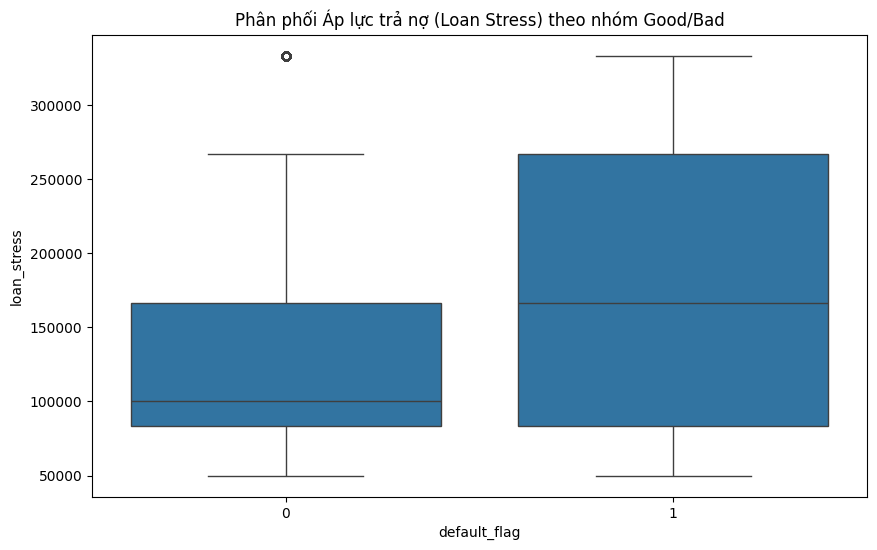

In [ ]:
# 5. VISUALIZE PHÂN PHỐI LOAN STRESS
plt.figure(figsize=(10, 6))
sns.boxplot(x='default_flag', y='loan_stress', data=df)
plt.title('Phân phối Áp lực trả nợ (Loan Stress) theo nhóm Good/Bad')
plt.show()